<a href="https://colab.research.google.com/github/aatiqa-ghazali/covid/blob/main/COVID-19-lesions-segmentation-using-unet_2D_with_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DIGITAL IMAGE PROCESSING-FINAL PROJECT**

# **Aatiqa Bint e Ghazali/FA19-RCS-001**

**TOPIC : COVID-19 LESIONS SEMANTIC-SEGMENTATION USING UNET-2D**

**Dataset:UESTC-COVID-19 Dataset**

For offical link of the data:[click here](https://faculty.uestc.edu.cn/HiLab/en/article/379152/content/3319.htm#article)

Link for 2D-slices of data on google drive:[click-here](https://drive.google.com/drive/folders/1n_t9BWBDGS6vLLG7bUkbcBrA518nABQa?usp=sharing)




# Importing libraries





In [ ]:
#IMPORTING IMPORTANT LIBRARIES
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

# Loading Dataset

In [ ]:

## Define constants
SEED = 1
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
##LINK OF DATASET/LOADING
data_dir = '/content/drive/MyDrive/newdata/slices/'
data_dir_train = os.path.join(data_dir, 'training')
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'data')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'label')

data_dir_test = os.path.join(data_dir, 'test')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'data')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'label')

NUM_TRAIN = 70
NUM_TEST = 50

NUM_OF_EPOCHS = 40

# Creating train & test generators with the augmentation of training data





In [ ]:
#take the images from all directories and feed them to the neural netwrok
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Fetching images from generators

In [ ]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 43133 images belonging to 1 classes.
Found 33148 images belonging to 1 classes.
Found 31193 images belonging to 1 classes.
Found 11985 images belonging to 1 classes.


In [ ]:
#display a label
def display(display_list):
    plt.figure(figsize=(30,30))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:

def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

# Creating Model/Arcitecture of UNET-2D

In [ ]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

# Summarising Model/Setting Epochs

In [ ]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 40, 80, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 40, 80, 32)   9248        conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 20, 40, 32)   0           conv2d_16[0][0]                  
________________________________________________________________________________________

# Fitting The Model/Traning Started

In [ ]:
history=model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
2/2 [==============================] - 8s 4s/step - loss: 0.6604 - accuracy: 0.9745 - val_loss: 0.5790 - val_accuracy: 0.9799
Epoch 2/40
2/2 [==============================] - 6s 3s/step - loss: 0.5297 - accuracy: 0.9850 - val_loss: 0.3049 - val_accuracy: 0.9938
Epoch 3/40
2/2 [==============================] - 24s 21s/step - loss: 0.2214 - accuracy: 0.9824 - val_loss: 0.4417 - val_accuracy: 0.9802
Epoch 4/40
2/2 [==============================] - 25s 22s/step - loss: 0.2890 - accuracy: 0.9853 - val_loss: 0.0453 - val_accuracy: 0.9963
Epoch 5/40
2/2 [==============================] - 24s 21s/step - loss: 0.0835 - accuracy: 0.9893 - val_loss: 0.0938 - val_accuracy: 0.9875
Epoch 6/40
2/2 [==============================] - 32s 29s/step - loss: 0.1040 - accuracy: 0.9870 - val_loss: 0.1272 - val_accuracy: 0.9803
Epoch 7/40
2/2 [==============================] - 27s 24s/step - loss: 0.0904 - accuracy: 0.9886 - val_loss: 0.1129 - val_accuracy: 0.9831
Epoch 8/40
2/2 [===============

# Plotting Curves after training using the history key

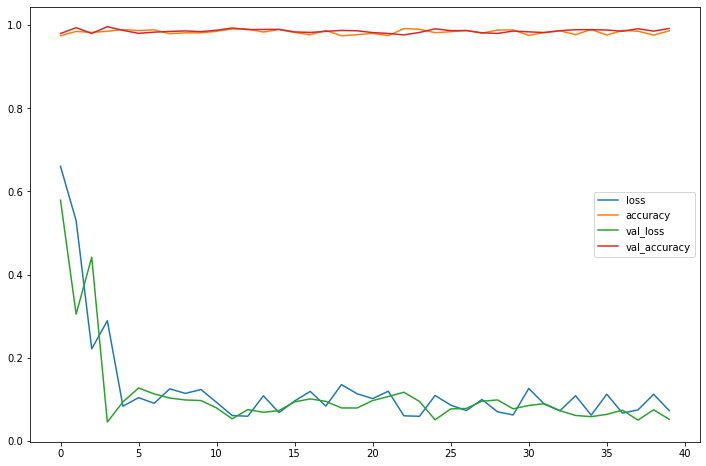

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.show()

# Plotting Accuracy Curves

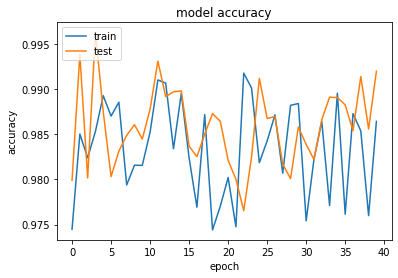

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Visualize How the error goes up and down during training

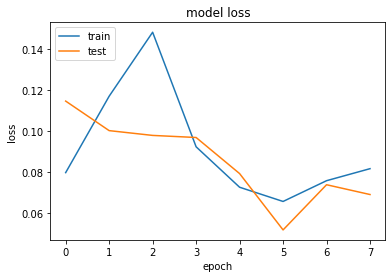

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# save the model for future predictions

In [ ]:
model.save(f'unet2D_results_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')


# Loading saved model

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/unet2D_results_40_80.h5')